In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager

In [34]:
# matplotlib에 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font
plt.rcParams['axes.unicode_minus'] = False  

## 계절별 전력 수요

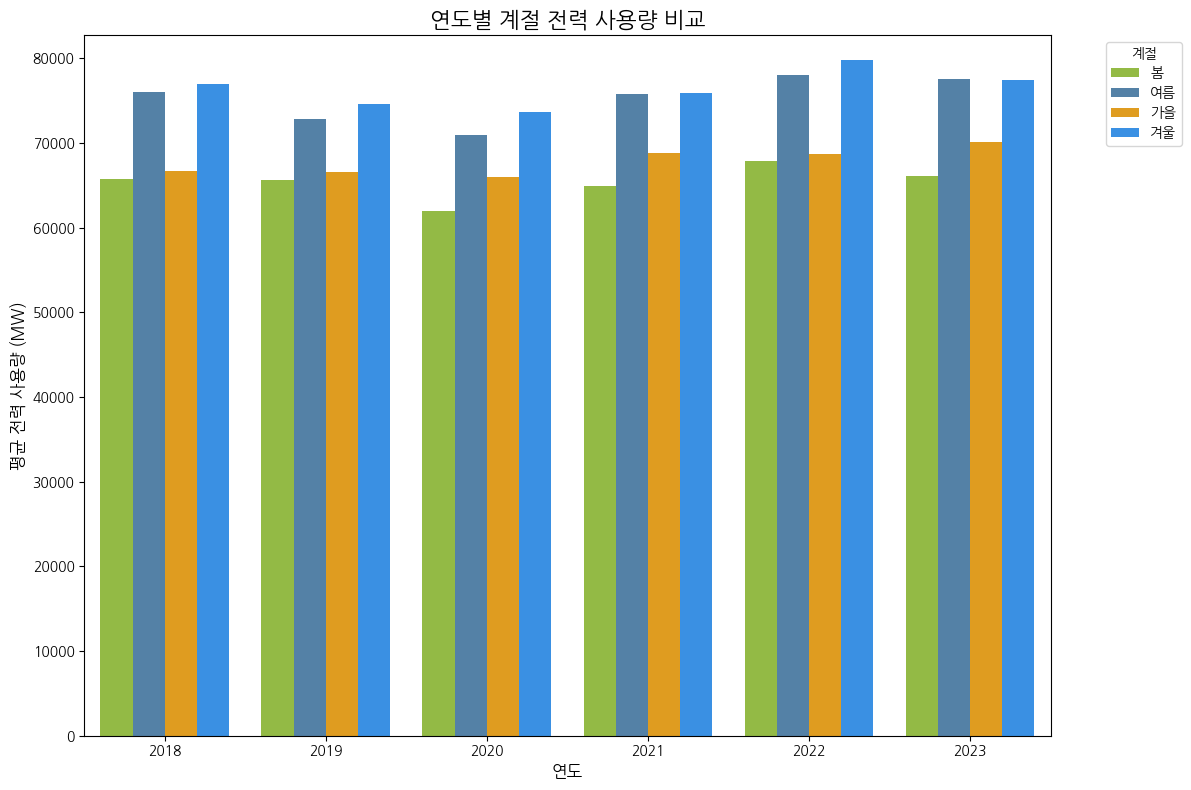

In [39]:
# 계절 매핑
seasons = {
    '1월': '겨울', '2월': '겨울', '3월': '봄', '4월': '봄', '5월': '봄',
    '6월': '여름', '7월': '여름', '8월': '여름', '9월': '가을', '10월': '가을',
    '11월': '가을', '12월': '겨울'
}

# 데이터 읽기 및 전처리
data = pd.read_csv('data/월별평균최대전력_2018-2023.csv', encoding='euc-kr')
data_melted = data.melt(id_vars=['연도'], value_vars=[col for col in data.columns if col != '연도'],
                        var_name='월', value_name='최대전력')
data_melted['계절'] = data_melted['월'].map(seasons)

# 계절별 색상 지정
season_colors = {
    '봄': '#9ACD32', '여름': '#4682B4', '가을': '#FFA500', '겨울': '#1E90FF'
}

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(data=data_melted, x='연도', y='최대전력', hue='계절', hue_order=['봄', '여름', '가을', '겨울'],
            palette=season_colors, errorbar=None)

plt.ylim(0, data_melted['최대전력'].max())
plt.title('연도별 계절 전력 사용량 비교', fontsize=16)
plt.xlabel('연도', fontsize=12)
plt.ylabel('평균 전력 사용량 (MW)', fontsize=12)
plt.legend(title='계절', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


## 발전원별 전력 생산